In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import MessagesState, StateGraph, START
from langgraph.prebuilt import create_react_agent, InjectedState
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import InMemorySaver


In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
#llm
llm = ChatGoogleGenerativeAI(model = 'gemini-2.5-flash')

In [4]:
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)
web_search_results = web_search.invoke("who is the mayor of NYC?")

print(web_search_results["results"][0]["content"])

Jump to content ## Contents * 1 History * View history * View history * Download QR code * Download as PDF The mayor's office is located in New York City Hall; it has jurisdiction over all five boroughs "Borough (New York City)") of New York City: Manhattan, Brooklyn, the Bronx, Staten Island and Queens. According to current law, the mayor is limited to two consecutive four-year terms in office but may run again after a four-year break. The current mayor is Eric Adams, who was elected on November 2, 2021, and took office shortly after midnight on January 1, 2022. ## History Its last political leader was an African American man named J. (**Discuss**) *(June 2025)* | * Robert W. * Staten Island Historical Society


In [5]:
from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(
    model=llm,
    tools=[web_search],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="research_agent",
)

In [6]:
def add(a: float, b: float):
    """Add two numbers."""
    return a + b


def multiply(a: float, b: float):
    """Multiply two numbers."""
    return a * b


def divide(a: float, b: float):
    """Divide two numbers."""
    return a / b


math_agent = create_react_agent(
    model=llm,
    tools=[add, multiply, divide],
    prompt=(
        "You are a math agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with math-related tasks\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="math_agent",
)

In [7]:
from langgraph_supervisor import create_supervisor

supervisor = create_supervisor(
    model=llm,
    agents=[research_agent, math_agent],
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    output_mode="last_message",
    add_handoff_messages = True,
).compile()

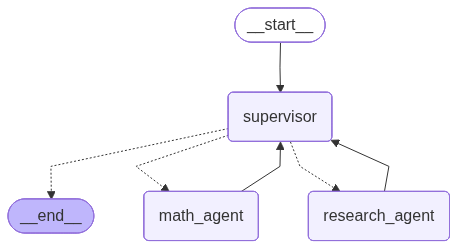

In [8]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_mermaid_png()))

In [ ]:
from langchain_core.messages import HumanMessage,AIMessage,ToolMessage,AIMessageChunk

def stream_supervisor(graph, user_input: str, config: dict = None):
    """
    Custom function to stream outputs while showing agent activity.
    """
    for stream_mode, chunk in graph.stream(
        {"messages": [HumanMessage(content=user_input)]},
        config=config or {},
        stream_mode=["updates", "messages"],
    ):


        if stream_mode == "updates":
            print(chunk) 
            for node, data in chunk.items():
                # Collect log
                print("----------------------------------")
                print(f"üîÑ **Update from node:** {node}")
                print("----------------------------------")
            if node == "supervisor":
                if "messages" in data:
                    for msg in data["messages"]:
                        # Handle only AI/Tool messages that are NEW
                        if isinstance(msg, AIMessage):
                        
                            print(f"ü§ñ : {msg.content}")





In [11]:
stream_supervisor(supervisor, "what is 5 multiplied by 6")


----------------------------------
üîÑ **Update from node:** supervisor
----------------------------------
ü§ñ : 
üîß **Using tool:** `multiply`
üîß **Using tool:** `transfer_back_to_supervisor`
----------------------------------
üîÑ **Update from node:** math_agent
----------------------------------
----------------------------------
üîÑ **Update from node:** supervisor
----------------------------------
ü§ñ : 
ü§ñ : 30
ü§ñ : Transferring back to supervisor
ü§ñ : The answer is 30.



In [75]:
initial_state = {
    "messages": [HumanMessage(content="what was India GDP in 2024")]
}



for stream_mode,chunk in supervisor.stream(
    initial_state,
    stream_mode=["updates", "messages"],
):
    print(stream_mode)
    print(chunk)


updates
{'supervisor': {'messages': [HumanMessage(content='what was India GDP in 2024', additional_kwargs={}, response_metadata={}, id='c1e6a150-01dc-4b0f-afcc-54c2f6df12ab'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'transfer_to_research_agent', 'arguments': '{}'}}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, name='supervisor', id='run--e88c45c9-bd6b-4387-b4f3-a6ae1de362df', tool_calls=[{'name': 'transfer_to_research_agent', 'args': {}, 'id': '440c3ced-93b7-41e1-8bb7-41277169d215', 'type': 'tool_call'}], usage_metadata={'input_tokens': 211, 'output_tokens': 55, 'total_tokens': 266, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 41}}), ToolMessage(content='Successfully transferred to research_agent', name='transfer_to_research_agent', tool_call_id='440c3ced-93b7-41e1-8bb7-41277169d215')]}}
messages
(AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavil